In [1]:
import torch
import tqdm
import Model
import Utils
import Loss
import Deeplearning
import torch.nn             as nn
import matplotlib.pyplot    as plt
import numpy                as np
import torch.optim          as optim

Utils.set_seed(42)
device = 'cuda'

npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[0, 0.5].npy"#"Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1, 0].npy"
loaded_data = Utils.read_npz_file(npz_file_path)

In [2]:
prediction_horizion     = 50
prediction_input_size   = 200
epochs                  = 1
_divition_factr         = 7
_alpha                  = 40

data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)
inception = Model.Encoder_Decoder(prediction_input_size).to(device)
criterion = Loss.custum_loss(alpha=_alpha)#torch.nn.MSELoss()
optimizer = optim.SGD(
                        inception.parameters(),
                        lr=5e-2,
                        momentum=0.9,
                        weight_decay=1e-4
                        )

In [ ]:


model, optimizer, report = Deeplearning.train(
                                                data_tensor                 = data_tensor[:100_000],
                                                prediction_input_size       = prediction_input_size,
                                                prediction_horizion         = prediction_horizion,
                                                _divition_factr             = _divition_factr,
                                                
                                                model                       = inception,
                                                model_name                  = "inception",
                                                epochs                      = epochs,
                                                load_saved_model            = False,
                                                ckpt_save_freq              = 1 ,
                                                ckpt_save_path              = "Save" ,
                                                ckpt_path                   = "Saved" ,
                                                report_path                 = "Saved" ,
                                                
                                                criterion                   = criterion,
                                                optimizer                   = optimizer,
                                                lr_schedulerr               = None,
                                                sleep_time                  = None,
                                                Validation_save_threshold   = None,
                                                device                      = 'cuda'    ,
                                                )

train:   0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 1/1 [06:35<00:00, 395.68s/it]


'\n    with alpha = 0.00001 loss=0.0442\n    with alpha = 0.1     loss=0.0440\n    with alpha = 1.5     loss=0.0421\n    with alpha = 15      loss=0.0232\n    \n    with alpha = 40      loss=-0.0119\n    \n'

# ChangeLog

1.  waiting to solution settle
2.  using only th acceleration data instead of the v and x
3.  

# Note
1.  try to remove the drop out in LSTM

2.  BE SURE data for chaotic case in Clean. (Training)
3.  Be sure for integration data is noise free.(Integrating)

In [ ]:
with torch.inference_mode():
    Batch = 2
    pred_hor = 6000
    x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]#+(torch.rand(size=[prediction_input_size],device=device)/_divition_factr)
    y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

    prediction_list = torch.zeros(size=[pred_hor]).to(device)

    decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
    for i in range(pred_hor):
        # prediction = inception.forward(x)
        prediction,(decoder_hidden, decoder_cell) = inception.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)#
        x =  torch.cat([x[1:],prediction],dim=0)
        prediction_list[i] = prediction



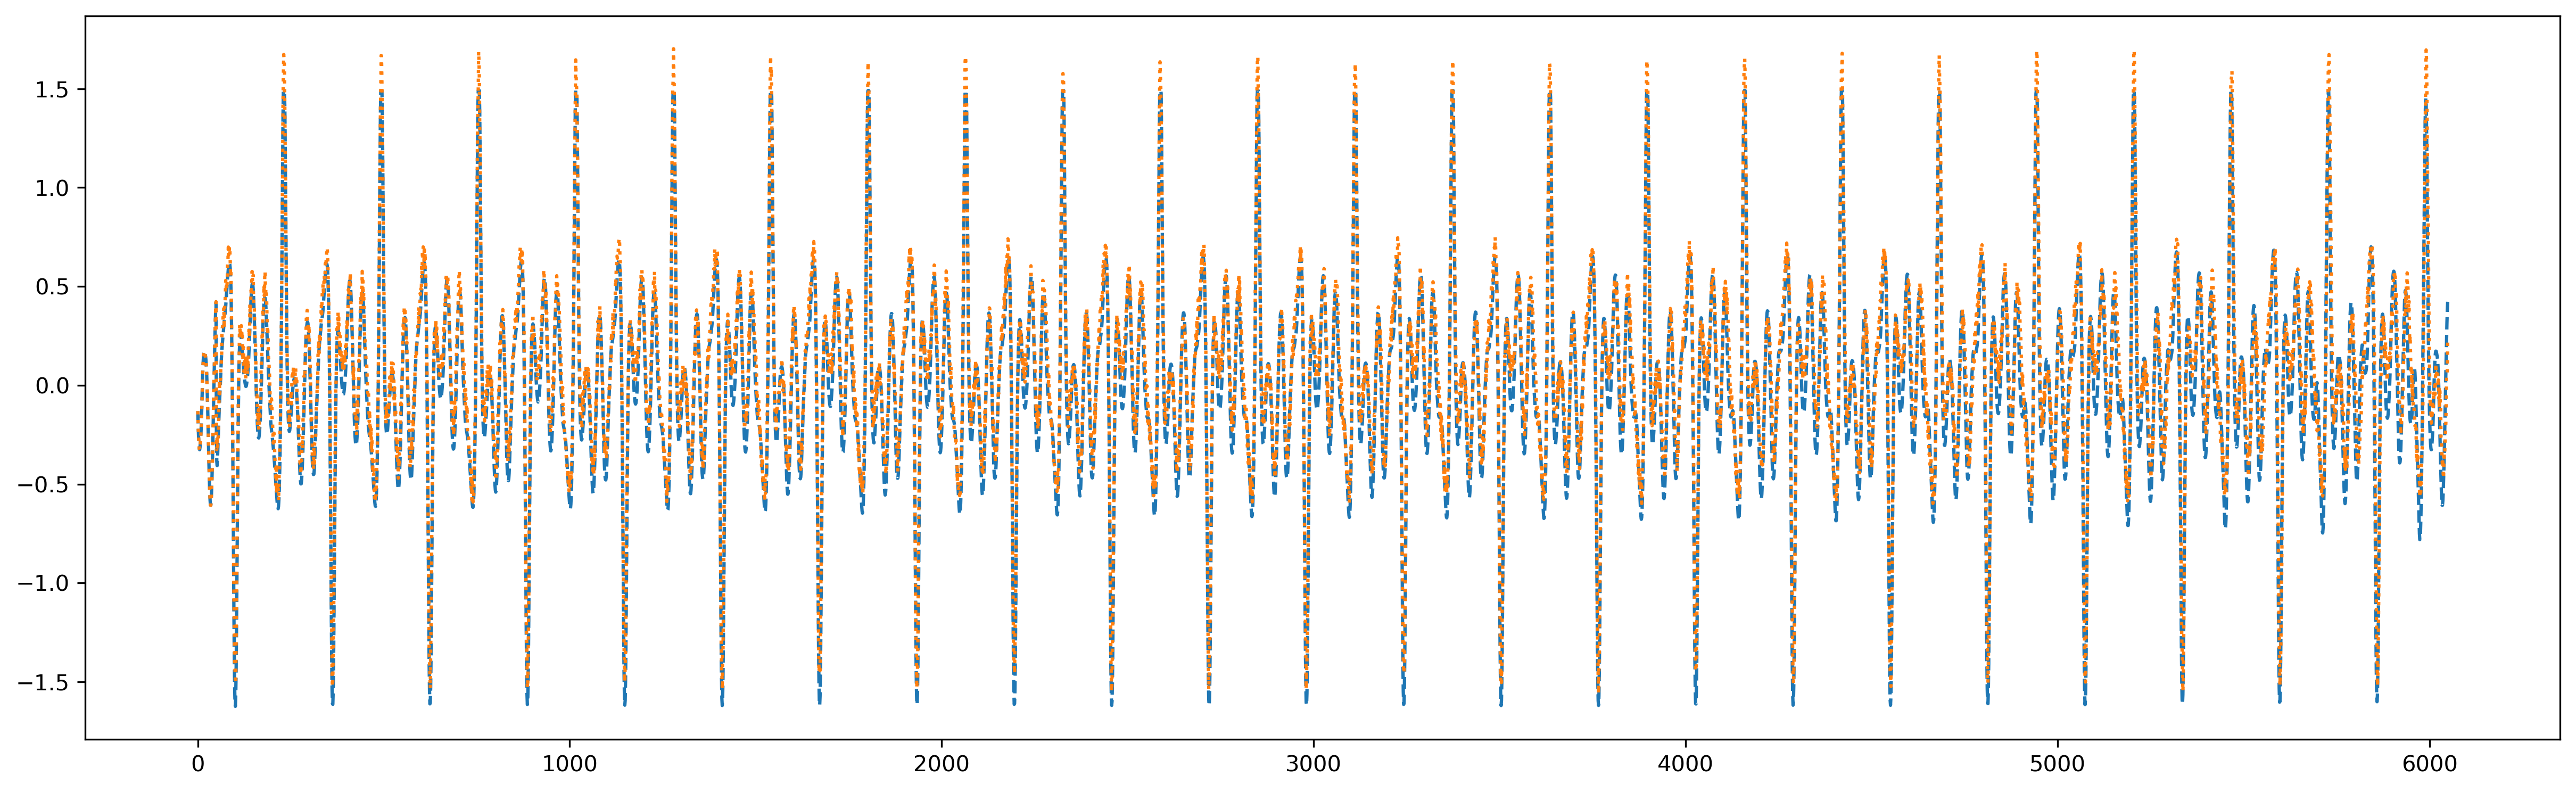

In [ ]:
plt.figure(figsize=(20, 6),dpi=300)
plt.plot( torch.concat([x[-50:],prediction_list[:]]                                              ).detach().cpu().numpy() ,linestyle='dashed', label="Displacement")
plt.plot( torch.concat([x[-50:],y[:]+torch.rand(size=[pred_hor],device=device)/_divition_factr]  ).detach().cpu().numpy() ,linestyle='dotted', label="Displacement")

plt.savefig(f"Gprediction alpha={_alpha}.png")

In [ ]:
vector = torch.concat([x[-50:],prediction_list[:]])[:].detach().cpu().numpy()
Utils.integrate_and_plot(vector,f"alpha = 0000 gamma=0.37",0.1,(0,vector.shape[0]//10))

AttributeError: module 'Utils' has no attribute 'integrate_and_plot'